In [1]:
import disgrid
import numpy as np
import matplotlib.pyplot as plt

In [4]:
d = disgrid.Data("output")

In [5]:
d.avail()

{'fluids': {'gas': {'2d': ['dens', 'energy', 'vrad', 'vtheta'],
   '1d': ['eta', 'rgy', 'ma', 'd'],
   'scalar': ['time step',
    'analysis time step',
    'physical time',
    'mass',
    'radius',
    'angular momentum',
    'total energy',
    'internal energy',
    'kinematic energy',
    'potential energy',
    'radial kinetic energy',
    'azimuthal kinetic energy',
    'eccentricity',
    'periastron',
    'viscous dissipation',
    'luminosity',
    'pdivv',
    'delta mass inner positive',
    'delta mass inner negative',
    'delta mass outer positive',
    'delta mass outer negative',
    'delta mass inner wave damping positive',
    'delta mass inner wave damping negative',
    'delta mass outer wave damping positive',
    'delta mass outer wave damping negative',
    'delta mass floor density positive',
    'aspect ratio']}},
 'planets': {},
 'Nsnapshots': 201}

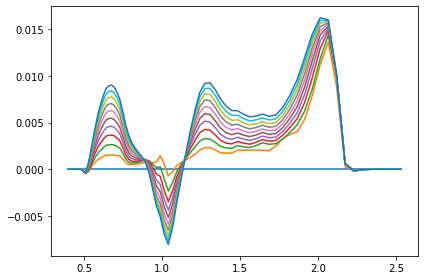

In [21]:
fig, ax = plt.subplots()

sigma = d.get(dim="2d", var="mass density", N=0)
sigma1d0 = np.average(sigma.data, axis=1)
Nmax = d.avail()["Nsnapshots"]
for n in range(0, Nmax, max(1, Nmax//10)):
    sigma = d.get(dim="2d", var="mass density", N=n)
    sigma1d = np.average(sigma.data, axis=1)
    rs = sigma.grid.get_coordinates("r")
    reldiff = (sigma1d - sigma1d0)/sigma1d0
    ax.plot(rs, reldiff)

(-0.2, 0.2)

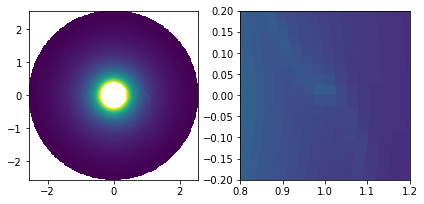

In [16]:
fig, axes = plt.subplots(ncols=2)

sigma = d.get(dim="2d", var="mass density", N=100)
sigma1d = np.average(sigma.data, axis=1)
rs = sigma.grid.get_interfaces("r")
phis = sigma.grid.get_interfaces("phi")
PHIS, RS = np.meshgrid(phis, rs)
X = RS*np.cos(PHIS)
Y = RS*np.sin(PHIS)

ax = axes[0]
ax.pcolormesh(X.value,Y.value, sigma.data.value)
ax.set_aspect("equal")

ax = axes[1]
ax.pcolormesh(X.value,Y.value, sigma.data.value)
ax.set_aspect("equal")
ax.set_xlim(0.8,1.2)
ax.set_ylim(-0.2,0.2)